# Assignment 2: Expedia Hotel Recommendations

#### Import relevant packages

In [2]:
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import os
import numpy as np
from project_modules.preprocessing import *
from project_modules.model_functions import *
import pickle
from boruta import BorutaPy
import logging
import optuna

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# os.chdir(r"C:\Users\jacbr\OneDrive\Documenten\vu-data-mining-techniques\Assignment 2")
os.chdir(r"C:\Users\Beheerder\Documents\vu-data-mining-techniques\Assignment 2")

c:\Users\Beheerder\Documents\vu-data-mining-techniques\.venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load train and test data

In [2]:
# train = add_target(pd.read_csv("data\curated_train_dev.csv", infer_datetime_format=True, parse_dates=[2]))
# test = pd.read_csv("data\curated_val_dev.csv", infer_datetime_format=True, parse_dates=[2])

# train = add_target(pd.read_csv(r"data\curated_train.csv", infer_datetime_format=True, parse_dates=[2]))
# test = pd.read_csv(r"data\curated_test.csv", infer_datetime_format=True, parse_dates=[2])




train.site_id, test.site_id = train.site_id.astype(int), test.site_id.astype(int)

In [3]:
test_vu = pd.read_csv(r"data\test_set_VU_DM.csv", infer_datetime_format=True, parse_dates=[2])
test_icdm = pd.read_csv(r"data\train.csv", infer_datetime_format=True, parse_dates=[2])

In [4]:
test_vu.head(5)

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,price_usd,promotion_flag,srch_destination_id,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,srch_query_affinity_score,orig_destination_distance,random_bool,comp1_rate,comp1_inv,comp1_rate_percent_diff,comp2_rate,comp2_inv,comp2_rate_percent_diff,comp3_rate,comp3_inv,comp3_rate_percent_diff,comp4_rate,comp4_inv,comp4_rate_percent_diff,comp5_rate,comp5_inv,comp5_rate_percent_diff,comp6_rate,comp6_inv,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff
0,1,2013-02-02 15:27:40,24,216,NaN,NaN,219,3180,3,4.5,1,2.94,0.0691,5.03,119.0,0,19222,1,10,2,0,1,0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2013-02-02 15:27:40,24,216,NaN,NaN,219,5543,3,4.5,1,2.64,0.0843,4.93,118.0,0,19222,1,10,2,0,1,0,NaN,NaN,0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2013-02-02 15:27:40,24,216,NaN,NaN,219,14142,2,3.5,1,2.71,0.0556,4.16,49.0,0,19222,1,10,2,0,1,0,NaN,NaN,0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2013-02-02 15:27:40,24,216,NaN,NaN,219,22393,3,4.5,1,2.40,0.0561,5.03,143.0,0,19222,1,10,2,0,1,0,NaN,NaN,0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,2013-02-02 15:27:40,24,216,NaN,NaN,219,24194,3,4.5,1,2.94,0.2090,4.72,79.0,0,19222,1,10,2,0,1,0,NaN,NaN,0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
test_icdm.head(5)

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,position,price_usd,promotion_flag,srch_destination_id,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,srch_query_affinity_score,orig_destination_distance,random_bool,comp1_rate,comp1_inv,comp1_rate_percent_diff,comp2_rate,comp2_inv,comp2_rate_percent_diff,comp3_rate,comp3_inv,comp3_rate_percent_diff,comp4_rate,comp4_inv,comp4_rate_percent_diff,comp5_rate,comp5_inv,comp5_rate_percent_diff,comp6_rate,comp6_inv,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool
0,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,893,3,3.5,1,2.83,0.0438,4.95,27,104.77,0,23246,1,0,4,0,1,1,NaN,NaN,1,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
1,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,10404,4,4.0,1,2.20,0.0149,5.03,26,170.74,0,23246,1,0,4,0,1,1,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
2,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,21315,3,4.5,1,2.20,0.0245,4.92,21,179.80,0,23246,1,0,4,0,1,1,NaN,NaN,1,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
3,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,27348,2,4.0,1,2.83,0.0125,4.39,34,602.77,0,23246,1,0,4,0,1,1,NaN,NaN,1,NaN,NaN,NaN,-1.0,0.0,5.0,-1.0,0.0,5.0,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,0.0,5.0,0,NaN,0
4,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,29604,4,3.5,1,2.64,0.1241,4.93,4,143.58,0,23246,1,0,4,0,1,1,NaN,NaN,1,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0


In [6]:
test_vu.columns

Index(['srch_id', 'date_time', 'site_id', 'visitor_location_country_id',
       'visitor_hist_starrating', 'visitor_hist_adr_usd', 'prop_country_id',
       'prop_id', 'prop_starrating', 'prop_review_score', 'prop_brand_bool',
       'prop_location_score1', 'prop_location_score2',
       'prop_log_historical_price', 'price_usd', 'promotion_flag',
       'srch_destination_id', 'srch_length_of_stay', 'srch_booking_window',
       'srch_adults_count', 'srch_children_count', 'srch_room_count',
       'srch_saturday_night_bool', 'srch_query_affinity_score',
       'orig_destination_distance', 'random_bool', 'comp1_rate', 'comp1_inv',
       'comp1_rate_percent_diff', 'comp2_rate', 'comp2_inv',
       'comp2_rate_percent_diff', 'comp3_rate', 'comp3_inv',
       'comp3_rate_percent_diff', 'comp4_rate', 'comp4_inv',
       'comp4_rate_percent_diff', 'comp5_rate', 'comp5_inv',
       'comp5_rate_percent_diff', 'comp6_rate', 'comp6_inv',
       'comp6_rate_percent_diff', 'comp7_rate', 'comp7_inv

In [9]:
test_icdm.loc[:, test_vu.columns]

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,price_usd,promotion_flag,srch_destination_id,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,srch_query_affinity_score,orig_destination_distance,random_bool,comp1_rate,comp1_inv,comp1_rate_percent_diff,comp2_rate,comp2_inv,comp2_rate_percent_diff,comp3_rate,comp3_inv,comp3_rate_percent_diff,comp4_rate,comp4_inv,comp4_rate_percent_diff,comp5_rate,comp5_inv,comp5_rate_percent_diff,comp6_rate,comp6_inv,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff
0,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,893,3,3.5,1,2.83,0.0438,4.95,104.77,0,23246,1,0,4,0,1,1,NaN,NaN,1,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN
1,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,10404,4,4.0,1,2.20,0.0149,5.03,170.74,0,23246,1,0,4,0,1,1,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN
2,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,21315,3,4.5,1,2.20,0.0245,4.92,179.80,0,23246,1,0,4,0,1,1,NaN,NaN,1,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN
3,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,27348,2,4.0,1,2.83,0.0125,4.39,602.77,0,23246,1,0,4,0,1,1,NaN,NaN,1,NaN,NaN,NaN,-1.0,0.0,5.0,-1.0,0.0,5.0,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,0.0,5.0
4,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,29604,4,3.5,1,2.64,0.1241,4.93,143.58,0,23246,1,0,4,0,1,1,NaN,NaN,1,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9917525,665574,2013-05-21 11:06:37,24,216,NaN,NaN,117,32019,4,3.5,0,2.48,0.0551,4.53,66.07,0,19246,2,7,1,0,1,0,NaN,NaN,0,NaN,NaN,NaN,1.0,0.0,22.0,1.0,0.0,127.0,-1.0,0.0,27.0,1.0,0.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9917526,665574,2013-05-21 11:06:37,24,216,NaN,NaN,117,33959,4,3.0,1,2.20,0.3344,4.39,67.10,0,19246,2,7,1,0,1,0,NaN,NaN,0,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,16.0,1.0,0.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9917527,665574,2013-05-21 11:06:37,24,216,NaN,NaN,117,35240,4,0.0,0,1.79,NaN,4.64,73.91,0,19246,2,7,1,0,1,0,NaN,NaN,0,NaN,NaN,NaN,1.0,0.0,55.0,0.0,0.0,NaN,0.0,0.0,16.0,0.0,0.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9917528,665574,2013-05-21 11:06:37,24,216,NaN,NaN,117,94437,4,0.0,0,2.94,0.0928,4.64,66.07,0,19246,2,7,1,0,1,0,NaN,NaN,0,NaN,NaN,NaN,1.0,0.0,43.0,1.0,0.0,43.0,-1.0,0.0,12.0,-1.0,0.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# train_idx, val_idx = next(
#         GroupShuffleSplit(n_splits=1, test_size=0.8).split(train, groups=train["srch_id"])
# )

# train_2, val = train.iloc[train_idx, :], train.iloc[val_idx, :]

### Workbench

In [4]:
def add_feature(df):
    group = df.groupby("prop_country_id")
    df["avg_price_prop_country_id"] = group["price_usd"].transform(lambda x: x.mean())
    df["median_price_prop_country_id"] = group["price_usd"].transform(
        lambda x: x.median())
    df["std_price_prop_country_id"] = group["price_usd"].transform(lambda x: x.std())
    df["avg_location_score2_prop_country_id"] = group["prop_location_score2"].transform(
        lambda x: x.mean()
    )
    df["median_location_score2_prop_country_id"] = group["prop_location_score2"].transform(
        lambda x: x.median()
    )
    df["std_location_score2_prop_country_id"] = group["prop_location_score2"].transform(
        lambda x: x.std()
    )
    df["avg_srch_booking_window_prop_country_id"] = group["srch_booking_window"].transform(
        lambda x: x.mean()
    )
    df["median_srch_booking_window_prop_country_id"] = group["srch_booking_window"].transform(
        lambda x: x.median()
    )
    df["std_srch_booking_window_prop_country_id"] = group["srch_booking_window"].transform(
        lambda x: x.std()
    )
    df["avg_srch_adults_count_prop_country_id"] = group["srch_adults_count"].transform(
        lambda x: x.mean()
    )
    df["median_srch_adults_count_prop_country_id"] = group["srch_adults_count"].transform(
        lambda x: x.median()
    )
    df["std_srch_adults_count_prop_country_id"] = group["srch_adults_count"].transform(
        lambda x: x.std()
    )
    df["avg_srch_saturday_night_bool_prop_country_id"] = group["srch_saturday_night_bool"].transform(
        lambda x: x.mean()
    )
    df["median_srch_saturday_night_bool_prop_country_id"] = group["srch_saturday_night_bool"].transform(
        lambda x: x.median()
    )
    df["std_srch_saturday_night_bool_prop_country_id"] = group["srch_saturday_night_bool"].transform(
        lambda x: x.std()
    )
    df["avg_srch_room_count_prop_country_id"] = group["srch_room_count"].transform(
        lambda x: x.mean()
    )
    df["median_srch_room_count_prop_country_id"] = group["srch_room_count"].transform(
        lambda x: x.median()
    )
    df["std_srch_room_count_prop_country_id"] = group["srch_room_count"].transform(
        lambda x: x.std()
    )
    df["avg_srch_children_count_prop_country_id"] = group["srch_children_count"].transform(
        lambda x: x.mean()
    )
    df["median_srch_children_count_prop_country_id"] = group["srch_children_count"].transform(
        lambda x: x.median()
    )
    df["std_srch_children_count_prop_country_id"] = group["srch_children_count"].transform(
        lambda x: x.std()
    )
    df["avg_srch_length_of_stay_prop_country_id"] = group["srch_length_of_stay"].transform(
        lambda x: x.mean()
    )
    df["median_srch_length_of_stay_prop_country_id"] = group["srch_length_of_stay"].transform(
        lambda x: x.median()
    )
    df["std_srch_length_of_stay_prop_country_id"] = group["srch_length_of_stay"].transform(
        lambda x: x.std()
    )
    df["avg_srch_query_affinity_score_prop_country_id"] = group["srch_query_affinity_score"].transform(
        lambda x: x.mean()
    )
    df["median_srch_query_affinity_score_prop_country_id"] = group["srch_query_affinity_score"].transform(
        lambda x: x.median()
    )
    df["std_srch_query_affinity_score_prop_country_id"] = group["srch_query_affinity_score"].transform(
        lambda x: x.std()
    )
    
    return df


# test = add_feature(test)
# train = add_feature(train)

# Fitting models

### LightGBM Ranker (LambdaRank)

First define the features and target

In [26]:
target = "target"

cols = [
    "prop_starrating",
    "prop_review_score",
    "prop_brand_bool",
    "prop_location_score1",
    "prop_location_score2",
    "prop_log_historical_price",
    "price_usd",
    "promotion_flag",
    "srch_destination_id",
    "srch_length_of_stay",
    "srch_booking_window",
    "srch_adults_count",
    "srch_children_count",
    "srch_room_count",
    "srch_saturday_night_bool",
    "srch_query_affinity_score",
    "orig_destination_distance",
    "random_bool",
    # "comp1_rate",
    # "comp1_inv",
    # "comp1_rate_percent_diff",
    # "comp2_rate",
    # "comp2_inv",
    # "comp2_rate_percent_diff",
    # "comp3_rate",
    # "comp3_inv",
    # "comp3_rate_percent_diff",
    # "comp4_rate",
    # "comp4_inv",
    # "comp4_rate_percent_diff",
    # "comp5_rate",
    # "comp5_inv",
    # "comp5_rate_percent_diff",
    # "comp6_rate",
    # "comp6_inv",
    # "comp6_rate_percent_diff",
    # "comp7_rate",
    # "comp7_inv",
    # "comp7_rate_percent_diff",
    # "comp8_rate",
    # "comp8_inv",
    # "comp8_rate_percent_diff",
    "visitor_hist_starrating",
    "visitor_hist_adr_usd",
    "visitor_hist_price_diff",
    "visitor_hist_starrating_diff",
    "norm_price_usd_wrt_srch_id",
    "norm_price_usd_wrt_prop_id",
    "norm_price_usd_wrt_srch_destination_id",
    "month",
    "norm_price_usd_wrt_month",
    "norm_price_usd_wrt_srch_booking_window",
    "norm_price_usd_wrt_prop_country_id",
    "norm_prop_log_historical_price_wrt_srch_id",
    "norm_prop_log_historical_price_wrt_prop_id",
    "norm_prop_log_historical_price_wrt_srch_destination_id",
    "norm_prop_log_historical_price_wrt_month",
    "norm_prop_log_historical_price_wrt_srch_booking_window",
    "norm_prop_log_historical_price_wrt_prop_country_id",
    "fee_per_person",
    "score2ma",
    "rank_price",
    "rank_location_score1",
    "rank_location_score2",
    "rank_starrating",
    "rank_review_score",
    "avg_price_prop_id",
    "median_price_prop_id",
    "std_price_prop_id",
    "avg_location_score2_prop_id",
    "median_location_score2_prop_id",
    "std_location_score2_prop_id",
    'avg_srch_booking_window_prop_id',
    'median_srch_booking_window_prop_id',
    'std_srch_booking_window_prop_id',
    'avg_srch_adults_count_prop_id',
    'median_srch_adults_count_prop_id',
    'std_srch_adults_count_prop_id',
    'avg_srch_saturday_night_bool_prop_id',
    'median_srch_saturday_night_bool_prop_id',
    'std_srch_saturday_night_bool_prop_id',
    'avg_srch_room_count_prop_id',
    'median_srch_room_count_prop_id',
    'std_srch_room_count_prop_id',
    'avg_srch_children_count_prop_id',
    'median_srch_children_count_prop_id',
    'std_srch_children_count_prop_id',
    'avg_srch_length_of_stay_prop_id',
    'median_srch_length_of_stay_prop_id',
    'std_srch_length_of_stay_prop_id',
    'avg_srch_query_affinity_score_prop_id',
    'median_srch_query_affinity_score_prop_id',
    'std_srch_query_affinity_score_prop_id',
    "mean_distance_to_other_prop",
    #    'booking_bool_encoded', 'click_bool_encoded',
    #    'target_encoded', 'position_encoded'
    # "catboost_target_encoded",
    # "catboost_position_encoded"
    "prop_id",
    "prop_country_id",
    "site_id",
    # 'avg_price_prop_country_id', 'median_price_prop_country_id', 'std_price_prop_country_id', 'avg_location_score2_prop_country_id', 'median_location_score2_prop_country_id', 'std_location_score2_prop_country_id', 'avg_srch_booking_window_prop_country_id', 'median_srch_booking_window_prop_country_id', 'std_srch_booking_window_prop_country_id', 'avg_srch_adults_count_prop_country_id', 'median_srch_adults_count_prop_country_id', 'std_srch_adults_count_prop_country_id', 'avg_srch_saturday_night_bool_prop_country_id', 'median_srch_saturday_night_bool_prop_country_id', 'std_srch_saturday_night_bool_prop_country_id', 'avg_srch_room_count_prop_country_id', 'median_srch_room_count_prop_country_id', 'std_srch_room_count_prop_country_id', 'avg_srch_children_count_prop_country_id', 'median_srch_children_count_prop_country_id', 'std_srch_children_count_prop_country_id', 'avg_srch_length_of_stay_prop_country_id', 'median_srch_length_of_stay_prop_country_id', 'std_srch_length_of_stay_prop_country_id', 'avg_srch_query_affinity_score_prop_country_id', 'median_srch_query_affinity_score_prop_country_id', 'std_srch_query_affinity_score_prop_country_id',
]

categoricals = ["prop_country_id", "site_id",
                "prop_brand_bool", "promotion_flag"]

id_cols = ["srch_id", "prop_id"]

len(cols)

73

Define the group ssizes for the training and validation set, which are needed for the LightGBMRanker

In [6]:
# train_2_groups = train_2.groupby("srch_id").size().to_numpy()
# val_groups = val.groupby("srch_id").size().to_numpy()
train_groups = train.groupby("srch_id").size().to_numpy()
test_groups = test.groupby("srch_id").size().to_numpy()

In [21]:
params = {
    "boosting_type": "gbdt",
    "learning_rate": 0.015,
    "n_estimators": 3000,
    "objective": "lambdarank",
}

with open(r"C:\Users\Beheerder\Documents\vu-data-mining-techniques\Assignment 2\output\optuna_run_05-18_2154.pickle", "rb") as f:
    study = pickle.load(f)
    
params.update(study.best_params)

In [22]:
params

{'boosting_type': 'gbdt',
 'learning_rate': 0.015,
 'n_estimators': 3000,
 'objective': 'lambdarank',
 'num_leaves': 896,
 'max_depth': 11,
 'min_data_in_leaf': 4400,
 'reg_alpha': 2.226105871597939,
 'reg_lambda': 9.064774956026373,
 'colsample_bytree': 0.26185846253790407}

In [8]:
logging.basicConfig(
    level=logging.INFO, filename=f"logs\\notebook_runs.log", encoding="utf-8")
logger = logging.getLogger()
lgb.register_logger(logger)

In [9]:
model = lgb.LGBMRanker(**params)
model.fit(
    train[cols],
    train[target],
    group=train_groups,
    categorical_feature=categoricals,
    # eval_at=[5],
    # eval_set=[(test[cols], test[target])],
    # eval_group=[test_groups]
)

LGBMRanker(colsample_bytree=0.26185846253790407, learning_rate=0.015,
           max_depth=11, min_data_in_leaf=4400, n_estimators=3000,
           num_leaves=896, objective='lambdarank', reg_alpha=2.226105871597939,
           reg_lambda=9.064774956026373)

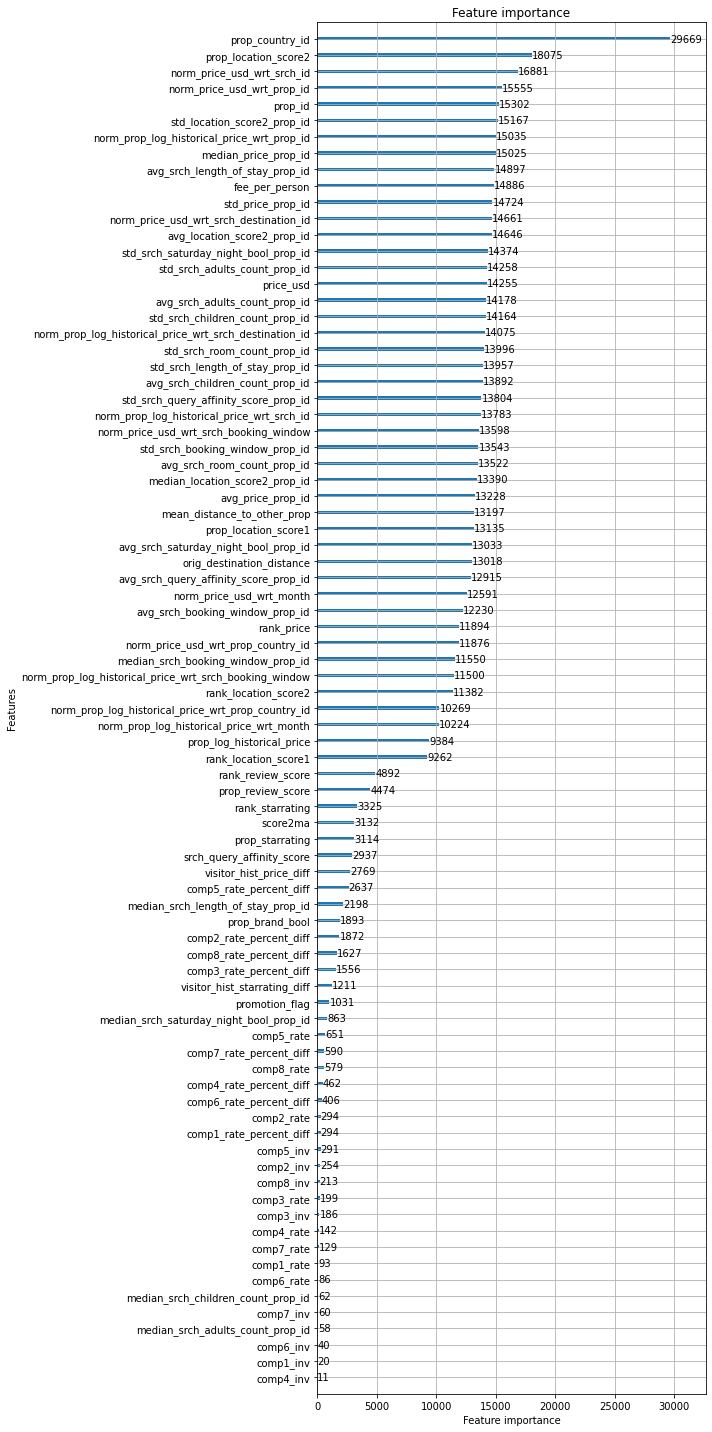

In [10]:
import matplotlib.pyplot as plt
fig, axis = plt.subplots(1, 1, figsize=(10,20))
lgb.plot_importance(model, height=0.2, ax=axis)
plt.tight_layout()

#### Evaluation of LightGBMRanker using NDCG@5

The following cell works for validation set where the target variable is available

In [11]:
# preds_lgb = get_ranking_from_pred(model, test[cols], test[id_cols].copy())

# calc_ndcg_submission(preds_lgb, test, k=5)

#### Submit predictions to Kaggle

The cell below is meant for yielding the output on the test set and can not be validated internally due to missing target column

In [12]:
# preds_test = get_ranking_from_pred(model, test[cols], test[id_cols].copy())

# # Save predictions for test set to csv

# file = f"predictions\predictions_{date_str()}.csv"
# preds_test.to_csv(file, index=False)

In [13]:
# !kaggle competitions submit -c 2nd-assignment-dmt2022 -f {file} -m "Submission using kaggle API"

### Pairwise models

In [14]:
import xgboost as xgb


params = {
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'n_estimators': 500,
    'objective': 'rank:pairwise',
    'num_leaves': 896,
    'max_depth': 11,
    'min_data_in_leaf': 4400,
    'reg_alpha': 2.226105871597939,
    'reg_lambda': 9.064774956026373,
    'colsample_bytree': 0.26185846253790407
}

model_xgb = xgb.XGBRanker(n_jobs=-1, **params)
model_xgb.fit(
    train[cols],
    train[target],
    group=train_groups,
    # eval_set=[(test[cols], test[target])],
    # eval_group=[test_groups]
)


[11:04:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "min_data_in_leaf", "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBRanker(base_score=0.5, booster='gbtree', callbacks=None, colsample_bylevel=1,
          colsample_bynode=1, colsample_bytree=0.26185846253790407,
          early_stopping_rounds=None, enable_categorical=False,
          eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
          importance_type=None, interaction_constraints='', learning_rate=0.05,
          max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=11,
          max_leaves=0, min_child_weight=1, min_data_in_leaf=4400, missing=nan,
          monotone_constraints='()', n_estimators=500, n_jobs=-1,
          num_leaves=896, num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [15]:
def get_ranking_from_pred(model, X, id_cols, query_id="srch_id", item_id="prop_id"):
    id_cols.loc[:, "pred"] = model.predict(X)
    res = id_cols.sort_values([query_id, "pred"], ascending=[True, False])

    return res

# preds_xgb = get_ranking_from_pred(model_xgb, test[cols], test[id_cols].copy())

# calc_ndcg_submission(preds_xgb, test, k=5)

## Ensemble of predictors

In [16]:
def minmax_predictions(preds):
    return preds.groupby("srch_id")["pred"].transform(lambda x: (x - x.min()) / (x.max() - x.min()))


def objective(trial, preds: np.ndarray, test: pd.DataFrame, id_array: pd.DataFrame):
    K = preds.shape[1]
    weights = [trial.suggest_float(f"weight_{i}", 0, 1) for i in range(K)]

    id_array.loc[:, "pred"] = np.average(preds, weights=weights, axis=1)

    final = id_array.sort_values(["srch_id", "pred"], ascending=[
                                 True, False])

    score = calc_ndcg_submission(final, test, k=5)

    return score


def run_optuna_ensemble(preds, test, id_array, n_trials=50):
    study_name = 'Optimize weights for ensemble prediction'
    study = optuna.create_study(direction="maximize", study_name=study_name)

    def obj(trial):
        return objective(trial, preds, test, id_array)

    study.optimize(obj, n_trials=n_trials, show_progress_bar=True)

    file = f"output\\ensemble_optuna_run_{date_str()}.pickle"
    
    with open(file, "wb") as f:
        pickle.dump(study, f)

    return study

In [17]:
res = test[id_cols].copy()
res["pred_lgb"] = model.predict(test[cols])
res["pred_xgb"] = model_xgb.predict(test[cols])


In [18]:
w = {'weight_0': 0.24204389733718726, 'weight_1': 0.9167390566979967}

res["final_pred"] = np.average(res.loc[:, ["pred_lgb", "pred_xgb"]], weights=[0.9167390566979967, 0.24204389733718726], axis=1)

In [19]:
# submission = res.sort_values(["srch_id", "pred_lgb"], ascending=[True, False]).loc[:, ["srch_id", "prop_id"]]

# file = f"predictions\predictions_{date_str()}.csv"
# submission.to_csv(file, index=False)

# !kaggle competitions submit -c 2nd-assignment-dmt2022 -f {file} -m "Submission using kaggle API"

Successfully submitted to 2nd Assignment DMT



  0%|          | 0.00/65.6M [00:00<?, ?B/s]
  0%|          | 104k/65.6M [00:00<01:06, 1.04MB/s]
  1%|          | 784k/65.6M [00:00<00:41, 1.65MB/s]
  2%|▏         | 1.18M/65.6M [00:00<00:29, 2.27MB/s]
  2%|▏         | 1.55M/65.6M [00:00<00:25, 2.67MB/s]
  3%|▎         | 1.93M/65.6M [00:00<00:22, 2.99MB/s]
  3%|▎         | 2.26M/65.6M [00:00<00:21, 3.10MB/s]
  4%|▍         | 2.59M/65.6M [00:01<00:23, 2.82MB/s]
  5%|▍         | 2.95M/65.6M [00:01<00:21, 3.07MB/s]
  5%|▌         | 3.32M/65.6M [00:01<00:19, 3.27MB/s]
  6%|▌         | 3.69M/65.6M [00:01<00:18, 3.43MB/s]
  6%|▌         | 4.05M/65.6M [00:01<00:18, 3.53MB/s]
  7%|▋         | 4.42M/65.6M [00:01<00:17, 3.60MB/s]
  7%|▋         | 4.79M/65.6M [00:01<00:17, 3.67MB/s]
  8%|▊         | 5.16M/65.6M [00:01<00:17, 3.70MB/s]
  8%|▊         | 5.52M/65.6M [00:01<00:16, 3.74MB/s]
  9%|▉         | 5.88M/65.6M [00:01<00:16, 3.73MB/s]
 10%|▉         | 6.25M/65.6M [00:02<00:16, 3.76MB/s]
 10%|█         | 6.62M/65.6M [00:02<00:16, 3.78MB/s]
 11

In [118]:
# run_optuna_ensemble(res.loc[:, ["pred_lgb", "pred_xgb"]], test, test[id_cols].copy())

[I 2022-05-22 21:18:45,892] A new study created in memory with name: Optimize weights for ensemble prediction
c:\Users\Beheerder\Documents\vu-data-mining-techniques\.venv\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()
  2%|▏         | 1/50 [00:05<04:25,  5.42s/it]

[I 2022-05-22 21:18:51,315] Trial 0 finished with value: 0.41137975017740275 and parameters: {'weight_0': 0.12328968119476191, 'weight_1': 0.043549924628551784}. Best is trial 0 with value: 0.41137975017740275.


  4%|▍         | 2/50 [00:10<04:17,  5.36s/it]

[I 2022-05-22 21:18:56,634] Trial 1 finished with value: 0.4085930723305797 and parameters: {'weight_0': 0.8002402086043529, 'weight_1': 0.10041516920614246}. Best is trial 0 with value: 0.41137975017740275.


  6%|▌         | 3/50 [00:16<04:14,  5.41s/it]

[I 2022-05-22 21:19:02,095] Trial 2 finished with value: 0.4103402052856567 and parameters: {'weight_0': 0.6381799363824715, 'weight_1': 0.1574880002002781}. Best is trial 0 with value: 0.41137975017740275.


  8%|▊         | 4/50 [00:21<04:06,  5.37s/it]

[I 2022-05-22 21:19:07,405] Trial 3 finished with value: 0.41440368827198115 and parameters: {'weight_0': 0.9132844791448727, 'weight_1': 0.7483674812973186}. Best is trial 3 with value: 0.41440368827198115.


 10%|█         | 5/50 [00:26<04:00,  5.34s/it]

[I 2022-05-22 21:19:12,686] Trial 4 finished with value: 0.4152661718724063 and parameters: {'weight_0': 0.6797923828119319, 'weight_1': 0.7391445758369098}. Best is trial 4 with value: 0.4152661718724063.


 12%|█▏        | 6/50 [00:32<03:53,  5.31s/it]

[I 2022-05-22 21:19:17,956] Trial 5 finished with value: 0.4158911944097673 and parameters: {'weight_0': 0.026695301407400174, 'weight_1': 0.46968492655473704}. Best is trial 5 with value: 0.4158911944097673.


 14%|█▍        | 7/50 [00:37<03:48,  5.31s/it]

[I 2022-05-22 21:19:23,246] Trial 6 finished with value: 0.4157311816080488 and parameters: {'weight_0': 0.7416257478335953, 'weight_1': 0.9740383087663699}. Best is trial 5 with value: 0.4158911944097673.


 16%|█▌        | 8/50 [00:42<03:41,  5.28s/it]

[I 2022-05-22 21:19:28,481] Trial 7 finished with value: 0.4092227637533752 and parameters: {'weight_0': 0.9043642643802512, 'weight_1': 0.1349247456656777}. Best is trial 5 with value: 0.4158911944097673.


 18%|█▊        | 9/50 [00:47<03:35,  5.26s/it]

[I 2022-05-22 21:19:33,689] Trial 8 finished with value: 0.4160511229513207 and parameters: {'weight_0': 0.05943206521469124, 'weight_1': 0.62060672935155}. Best is trial 8 with value: 0.4160511229513207.


 20%|██        | 10/50 [00:53<03:30,  5.27s/it]

[I 2022-05-22 21:19:38,983] Trial 9 finished with value: 0.41568954767680955 and parameters: {'weight_0': 0.6032696603711979, 'weight_1': 0.7970816715045012}. Best is trial 8 with value: 0.4160511229513207.


 22%|██▏       | 11/50 [00:58<03:25,  5.27s/it]

[I 2022-05-22 21:19:44,235] Trial 10 finished with value: 0.41590287180393687 and parameters: {'weight_0': 0.2525371231179158, 'weight_1': 0.4309612981864356}. Best is trial 8 with value: 0.4160511229513207.


 24%|██▍       | 12/50 [01:03<03:21,  5.30s/it]

[I 2022-05-22 21:19:49,612] Trial 11 finished with value: 0.4155928218661884 and parameters: {'weight_0': 0.288486153933107, 'weight_1': 0.39958731226179156}. Best is trial 8 with value: 0.4160511229513207.


 26%|██▌       | 13/50 [01:09<03:17,  5.33s/it]

[I 2022-05-22 21:19:55,019] Trial 12 finished with value: 0.4152033056042917 and parameters: {'weight_0': 0.3220300647474982, 'weight_1': 0.36413988501330263}. Best is trial 8 with value: 0.4160511229513207.


 28%|██▊       | 14/50 [01:14<03:11,  5.32s/it]

[I 2022-05-22 21:20:00,298] Trial 13 finished with value: 0.41624394281999155 and parameters: {'weight_0': 0.30216221590321113, 'weight_1': 0.6254125756494598}. Best is trial 13 with value: 0.41624394281999155.


 30%|███       | 15/50 [01:19<03:05,  5.31s/it]

[I 2022-05-22 21:20:05,585] Trial 14 finished with value: 0.4156716182732989 and parameters: {'weight_0': 0.4419750528941825, 'weight_1': 0.6176878439269207}. Best is trial 13 with value: 0.41624394281999155.


 32%|███▏      | 16/50 [01:24<03:00,  5.30s/it]

[I 2022-05-22 21:20:10,867] Trial 15 finished with value: 0.4156084123212631 and parameters: {'weight_0': 0.0037041077734661296, 'weight_1': 0.5753745788386382}. Best is trial 13 with value: 0.41624394281999155.


 34%|███▍      | 17/50 [01:30<02:58,  5.40s/it]

[I 2022-05-22 21:20:16,504] Trial 16 finished with value: 0.4158710611905057 and parameters: {'weight_0': 0.15812714914687187, 'weight_1': 0.2829067120967438}. Best is trial 13 with value: 0.41624394281999155.


 36%|███▌      | 18/50 [01:35<02:52,  5.38s/it]

[I 2022-05-22 21:20:21,829] Trial 17 finished with value: 0.4161166383832517 and parameters: {'weight_0': 0.4540025382090995, 'weight_1': 0.8963521269860139}. Best is trial 13 with value: 0.41624394281999155.


 38%|███▊      | 19/50 [01:41<02:47,  5.40s/it]

[I 2022-05-22 21:20:27,288] Trial 18 finished with value: 0.4161328764398384 and parameters: {'weight_0': 0.41859537109210687, 'weight_1': 0.9895522360951436}. Best is trial 13 with value: 0.41624394281999155.


 40%|████      | 20/50 [01:46<02:41,  5.38s/it]

[I 2022-05-22 21:20:32,609] Trial 19 finished with value: 0.41576857595839284 and parameters: {'weight_0': 0.5340341734040237, 'weight_1': 0.8756619822380974}. Best is trial 13 with value: 0.41624394281999155.


 42%|████▏     | 21/50 [01:52<02:35,  5.37s/it]

[I 2022-05-22 21:20:37,954] Trial 20 finished with value: 0.41644919970374045 and parameters: {'weight_0': 0.34243074165691284, 'weight_1': 0.9922153177820202}. Best is trial 20 with value: 0.41644919970374045.


 44%|████▍     | 22/50 [01:57<02:29,  5.34s/it]

[I 2022-05-22 21:20:43,212] Trial 21 finished with value: 0.4163095639356097 and parameters: {'weight_0': 0.3330321878638109, 'weight_1': 0.9961326116360417}. Best is trial 20 with value: 0.41644919970374045.


 46%|████▌     | 23/50 [02:02<02:26,  5.42s/it]

[I 2022-05-22 21:20:48,827] Trial 22 finished with value: 0.4160893629478204 and parameters: {'weight_0': 0.3466856416347859, 'weight_1': 0.8751027919106289}. Best is trial 20 with value: 0.41644919970374045.


 48%|████▊     | 24/50 [02:09<02:29,  5.76s/it]

[I 2022-05-22 21:20:55,371] Trial 23 finished with value: 0.4164522776783703 and parameters: {'weight_0': 0.20662293668919873, 'weight_1': 0.6975717659454094}. Best is trial 23 with value: 0.4164522776783703.


 50%|█████     | 25/50 [02:14<02:20,  5.64s/it]

[I 2022-05-22 21:21:00,723] Trial 24 finished with value: 0.4162151917803672 and parameters: {'weight_0': 0.191218801379054, 'weight_1': 0.9984982486897682}. Best is trial 23 with value: 0.4164522776783703.


 52%|█████▏    | 26/50 [02:20<02:13,  5.55s/it]

[I 2022-05-22 21:21:06,070] Trial 25 finished with value: 0.4165237595157517 and parameters: {'weight_0': 0.22070499850051262, 'weight_1': 0.798897247830491}. Best is trial 25 with value: 0.4165237595157517.


 54%|█████▍    | 27/50 [02:25<02:05,  5.46s/it]

[I 2022-05-22 21:21:11,335] Trial 26 finished with value: 0.4165743787888988 and parameters: {'weight_0': 0.20898445183681405, 'weight_1': 0.719045132922864}. Best is trial 26 with value: 0.4165743787888988.


 56%|█████▌    | 28/50 [02:30<01:59,  5.43s/it]

[I 2022-05-22 21:21:16,702] Trial 27 finished with value: 0.41644700646889793 and parameters: {'weight_0': 0.2188231470299693, 'weight_1': 0.7151551268388237}. Best is trial 26 with value: 0.4165743787888988.


 58%|█████▊    | 29/50 [02:36<01:53,  5.41s/it]

[I 2022-05-22 21:21:22,057] Trial 28 finished with value: 0.41626244707485993 and parameters: {'weight_0': 0.0883033268037778, 'weight_1': 0.5260972109859641}. Best is trial 26 with value: 0.4165743787888988.


 60%|██████    | 30/50 [02:41<01:48,  5.40s/it]

[I 2022-05-22 21:21:27,439] Trial 29 finished with value: 0.4161558806923464 and parameters: {'weight_0': 0.12364948587245925, 'weight_1': 0.6875484354256429}. Best is trial 26 with value: 0.4165743787888988.


 62%|██████▏   | 31/50 [02:46<01:41,  5.36s/it]

[I 2022-05-22 21:21:32,704] Trial 30 finished with value: 0.41616334718856607 and parameters: {'weight_0': 0.14519472122329796, 'weight_1': 0.7951037036643873}. Best is trial 26 with value: 0.4165743787888988.


 64%|██████▍   | 32/50 [02:52<01:35,  5.33s/it]

[I 2022-05-22 21:21:37,972] Trial 31 finished with value: 0.4161138374060806 and parameters: {'weight_0': 0.3844038056941571, 'weight_1': 0.8186112414991826}. Best is trial 26 with value: 0.4165743787888988.


 66%|██████▌   | 33/50 [02:57<01:30,  5.31s/it]

[I 2022-05-22 21:21:43,226] Trial 32 finished with value: 0.41653840991816726 and parameters: {'weight_0': 0.22455853634773917, 'weight_1': 0.9118513217456423}. Best is trial 26 with value: 0.4165743787888988.


 68%|██████▊   | 34/50 [03:02<01:24,  5.30s/it]

[I 2022-05-22 21:21:48,493] Trial 33 finished with value: 0.41661039343070533 and parameters: {'weight_0': 0.24204389733718726, 'weight_1': 0.9167390566979967}. Best is trial 33 with value: 0.41661039343070533.


 70%|███████   | 35/50 [03:07<01:19,  5.31s/it]

[I 2022-05-22 21:21:53,821] Trial 34 finished with value: 0.416496129511756 and parameters: {'weight_0': 0.24778834340296305, 'weight_1': 0.9061394765688581}. Best is trial 33 with value: 0.41661039343070533.


 72%|███████▏  | 36/50 [03:13<01:14,  5.30s/it]

[I 2022-05-22 21:21:59,109] Trial 35 finished with value: 0.4160839547436931 and parameters: {'weight_0': 0.09567336382975014, 'weight_1': 0.8438683313421432}. Best is trial 33 with value: 0.41661039343070533.


 74%|███████▍  | 37/50 [03:18<01:08,  5.29s/it]

[I 2022-05-22 21:22:04,370] Trial 36 finished with value: 0.4162462311402902 and parameters: {'weight_0': 0.1590926023770036, 'weight_1': 0.9355415883774697}. Best is trial 33 with value: 0.41661039343070533.


 76%|███████▌  | 38/50 [03:23<01:03,  5.27s/it]

[I 2022-05-22 21:22:09,611] Trial 37 finished with value: 0.41574878914457963 and parameters: {'weight_0': 0.4968489758521263, 'weight_1': 0.7670447297399194}. Best is trial 33 with value: 0.41661039343070533.


 78%|███████▊  | 39/50 [03:29<00:58,  5.29s/it]

[I 2022-05-22 21:22:14,951] Trial 38 finished with value: 0.41641919559896684 and parameters: {'weight_0': 0.2549131413201122, 'weight_1': 0.8376622464377272}. Best is trial 33 with value: 0.41661039343070533.


 80%|████████  | 40/50 [03:34<00:52,  5.28s/it]

[I 2022-05-22 21:22:20,208] Trial 39 finished with value: 0.4151775727036757 and parameters: {'weight_0': 0.9812902524120384, 'weight_1': 0.9346312486079321}. Best is trial 33 with value: 0.41661039343070533.


 82%|████████▏ | 41/50 [03:39<00:47,  5.29s/it]

[I 2022-05-22 21:22:25,503] Trial 40 finished with value: 0.415857658132271 and parameters: {'weight_0': 0.06143322179849686, 'weight_1': 0.7550034989139401}. Best is trial 33 with value: 0.41661039343070533.


 84%|████████▍ | 42/50 [03:44<00:42,  5.28s/it]

[I 2022-05-22 21:22:30,759] Trial 41 finished with value: 0.4164857901208027 and parameters: {'weight_0': 0.24717761877253522, 'weight_1': 0.9150131700335804}. Best is trial 33 with value: 0.41661039343070533.


 86%|████████▌ | 43/50 [03:50<00:36,  5.27s/it]

[I 2022-05-22 21:22:36,023] Trial 42 finished with value: 0.4165514457590758 and parameters: {'weight_0': 0.1969877035557959, 'weight_1': 0.8660314389008161}. Best is trial 33 with value: 0.41661039343070533.


 88%|████████▊ | 44/50 [03:55<00:31,  5.27s/it]

[I 2022-05-22 21:22:41,287] Trial 43 finished with value: 0.4164114696117664 and parameters: {'weight_0': 0.1857025153147548, 'weight_1': 0.8352674190489724}. Best is trial 33 with value: 0.41661039343070533.


 90%|█████████ | 45/50 [04:00<00:26,  5.28s/it]

[I 2022-05-22 21:22:46,581] Trial 44 finished with value: 0.4165624598453124 and parameters: {'weight_0': 0.27423435217746983, 'weight_1': 0.9451170650176399}. Best is trial 33 with value: 0.41661039343070533.


 92%|█████████▏| 46/50 [04:06<00:21,  5.29s/it]

[I 2022-05-22 21:22:51,913] Trial 45 finished with value: 0.4085857164212955 and parameters: {'weight_0': 0.38477844639473535, 'weight_1': 0.04778164293237891}. Best is trial 33 with value: 0.41661039343070533.


 94%|█████████▍| 47/50 [04:11<00:15,  5.28s/it]

[I 2022-05-22 21:22:57,154] Trial 46 finished with value: 0.4161251838643113 and parameters: {'weight_0': 0.29694813396794684, 'weight_1': 0.6567314848641039}. Best is trial 33 with value: 0.41661039343070533.


 96%|█████████▌| 48/50 [04:16<00:10,  5.27s/it]

[I 2022-05-22 21:23:02,398] Trial 47 finished with value: 0.4153525441986592 and parameters: {'weight_0': 0.7652526885762567, 'weight_1': 0.9443710935680706}. Best is trial 33 with value: 0.41661039343070533.


 98%|█████████▊| 49/50 [04:21<00:05,  5.27s/it]

[I 2022-05-22 21:23:07,666] Trial 48 finished with value: 0.4162941055034221 and parameters: {'weight_0': 0.28381685183920086, 'weight_1': 0.8700357771499392}. Best is trial 33 with value: 0.41661039343070533.


100%|██████████| 50/50 [04:27<00:00,  5.34s/it]

[I 2022-05-22 21:23:12,946] Trial 49 finished with value: 0.4158798954664947 and parameters: {'weight_0': 0.05372257251956941, 'weight_1': 0.9515923753738896}. Best is trial 33 with value: 0.41661039343070533.


### Pointwise models

In [ ]:
cols = [
    "prop_starrating",
    "prop_review_score",
    "prop_brand_bool",
    "prop_location_score1",
    "prop_location_score2",
    "prop_log_historical_price",
    "price_usd",
    "promotion_flag",
    "srch_destination_id",
    "srch_length_of_stay",
    "srch_booking_window",
    "srch_adults_count",
    "srch_children_count",
    "srch_room_count",
    "srch_saturday_night_bool",
    "srch_query_affinity_score",
    "orig_destination_distance",
    "random_bool",
    # "comp1_rate",
    # "comp1_inv",
    # "comp1_rate_percent_diff",
    # "comp2_rate",
    # "comp2_inv",
    # "comp2_rate_percent_diff",
    # "comp3_rate",
    # "comp3_inv",
    # "comp3_rate_percent_diff",
    # "comp4_rate",
    # "comp4_inv",
    # "comp4_rate_percent_diff",
    # "comp5_rate",
    # "comp5_inv",
    # "comp5_rate_percent_diff",
    # "comp6_rate",
    # "comp6_inv",
    # "comp6_rate_percent_diff",
    # "comp7_rate",
    # "comp7_inv",
    # "comp7_rate_percent_diff",
    # "comp8_rate",
    # "comp8_inv",
    # "comp8_rate_percent_diff",
    "visitor_hist_starrating",
    "visitor_hist_adr_usd",
    "visitor_hist_price_diff",
    "visitor_hist_starrating_diff",
    "norm_price_usd_wrt_srch_id",
    "norm_price_usd_wrt_prop_id",
    "norm_price_usd_wrt_srch_destination_id",
    "month",
    "norm_price_usd_wrt_month",
    "norm_price_usd_wrt_srch_booking_window",
    "norm_price_usd_wrt_prop_country_id",
    "norm_prop_log_historical_price_wrt_srch_id",
    "norm_prop_log_historical_price_wrt_prop_id",
    "norm_prop_log_historical_price_wrt_srch_destination_id",
    "norm_prop_log_historical_price_wrt_month",
    "norm_prop_log_historical_price_wrt_srch_booking_window",
    "norm_prop_log_historical_price_wrt_prop_country_id",
    "fee_per_person",
    "score2ma",
    "rank_price",
    "rank_location_score1",
    "rank_location_score2",
    "rank_starrating",
    "rank_review_score",
    "avg_price_prop_id",
    "median_price_prop_id",
    "std_price_prop_id",
    "avg_location_score2_prop_id",
    "median_location_score2_prop_id",
    "std_location_score2_prop_id",
    #    'booking_bool_encoded', 'click_bool_encoded',
    #    'target_encoded', 'position_encoded'
    # "catboost_target_encoded",
    # "catboost_position_encoded"
    "prop_id",
    "prop_country_id",
    "site_id",
]

In [24]:
params = {
    "boosting_type": "gbdt",
    "num_leaves": 31,
    "max_depth": -1,
    "learning_rate": 0.05,
    "n_estimators": 500,
    "objective": "regression",
}

with open(r"C:\Users\Beheerder\Documents\vu-data-mining-techniques\Assignment 2\output\optuna_run_05-18_2154.pickle", "rb") as f:
    study = pickle.load(f)
    
params.update(study.best_params)
params

{'boosting_type': 'gbdt',
 'num_leaves': 896,
 'max_depth': 11,
 'learning_rate': 0.05,
 'n_estimators': 500,
 'objective': 'regression',
 'min_data_in_leaf': 4400,
 'reg_alpha': 2.226105871597939,
 'reg_lambda': 9.064774956026373,
 'colsample_bytree': 0.26185846253790407}

In [32]:
dff = get_balanced_set(train)

model2 = lgb.LGBMRegressor(**params)
model2.fit(
    dff[cols],
    dff[target]
)

[LightGBM] [Warning] min_data_in_leaf is set=4400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4400


LGBMRegressor(colsample_bytree=0.26185846253790407, learning_rate=0.05,
              max_depth=11, min_data_in_leaf=4400, n_estimators=500,
              num_leaves=896, objective='regression',
              reg_alpha=2.226105871597939, reg_lambda=9.064774956026373)

In [35]:
res = test[id_cols]
res['score'] = model2.predict(test[cols])

preds = res.sort_values(["srch_id", "score"], ascending=[True, False])[["srch_id", "prop_id"]]

calc_ndcg_submission(preds, test, k=5)

C:\Users\Beheerder\AppData\Local\Temp\ipykernel_15456\2599038185.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res['score'] = model2.predict(test[cols])


0.380329356534703

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

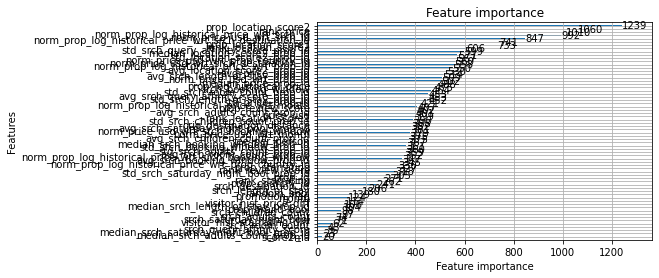

In [55]:
lgb.plot_importance(model2)